# <center> Costa Rican Household Poverty Level Prediction </center>

---

# Content
- [Problem Statement](#Problem-Statement)
- [Main Objective](#Main-Objective)
- [Data Exploratory](#Data-Exploratory)
- [Data Munging](#Data-Munging)

# Problem Statement

---

Many social programs have a hard time making sure the right people are given enough aid. It’s especially tricky when a program focuses on the poorest segment of the population. The world’s poorest typically can’t provide the necessary income and expense records to prove that they qualify.

In Latin America, one popular method uses an algorithm to verify income qualification. It’s called the Proxy Means Test (or PMT). With PMT, agencies use a model that considers a family’s observable household attributes like the material of their walls and ceiling, or the assets found in the home to classify them and predict their level of need.

While this is an improvement, accuracy remains a problem as the region’s population grows and poverty declines.

# Main Objective

---

We strive to improve the accuracy of the predicting households' level of need by proposing a using a new model - Linear Regression. With the given variables in the dataset, we set out to predict poverty on a `household level`.

# Dataset Information

---

Core Data fields

    Id - a unique identifier for each row.
    Target - the target is an ordinal variable indicating groups of income levels. 
        1 = extreme poverty 
        2 = moderate poverty 
        3 = vulnerable households 
        4 = non vulnerable households
    idhogar - this is a unique identifier for each household. This can be used to create household-wide features, etc. 

All rows in a given household will have a matching value for this identifier.
parentesco1 - indicates if this person is the head of the household.
This data contains 142 total columns.

All other data fields [can be found here](https://www.kaggle.com/c/costa-rican-household-poverty-prediction/data).


# Data Munging

---

Importing libraries and set graph style

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set a few plotting defaults
%matplotlib inline
plt.style.use('seaborn')
plt.rcParams['font.size'] = 18
plt.rcParams['patch.edgecolor'] = 'k'

#### Reading training dataset

In [2]:
train = pd.read_csv("train.csv")

We first find out the data types for each column

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


This tells us there are 130 integer columns, 8 float (numeric) columns, and 5 object columns. The object columns might pose an issue because they cannot be fed directly into a machine learning model.

Lets take a look at the 5  columns that are `object` datatypes

In [4]:
train.select_dtypes('object').head()

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


We will not be including the individual id and household id in our machine learning model, so lets investigate the other 3 columns that we may put into the machine learning model.

 According to the documentation for these columns:

* `dependency`: Dependency rate, calculated = (number of members of the household younger than 19 or older than 64)/(number of member of household between 19 and 64)
* `edjefe`: years of education of male head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0
* `edjefa`: years of education of female head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0

For now, lets dive deeper into the 3 columns to see what values they contain.
For `dependency` :

In [5]:
train.select_dtypes('object')['dependency'].value_counts()

yes          2192
no           1747
.5           1497
2             730
1.5           713
.33333334     598
.66666669     487
8             378
.25           260
3             236
4             100
.75            98
.2             90
1.3333334      84
.40000001      84
2.5            77
5              24
.80000001      18
3.5            18
1.25           18
2.25           13
.71428573      12
1.2            11
1.75           11
.83333331      11
.22222222      11
.2857143        9
1.6666666       8
.60000002       8
.16666667       7
6               7
Name: dependency, dtype: int64

In [6]:
train.select_dtypes('object')['edjefe'].value_counts()

no     3762
6      1845
11      751
9       486
3       307
15      285
8       257
7       234
5       222
14      208
17      202
2       194
4       137
16      134
yes     123
12      113
10      111
13      103
21       43
18       19
19       14
20        7
Name: edjefe, dtype: int64

In [7]:
train.select_dtypes('object')['edjefa'].value_counts()

no     6230
6       947
11      399
9       237
8       217
15      188
7       179
5       176
3       152
4       136
14      120
16      113
10       96
2        84
17       76
12       72
yes      69
13       52
21        5
19        4
18        3
20        2
Name: edjefa, dtype: int64

As we scan through, realise that all values are float or integer except for string of `yes` and `no`

#### Since they mentioned that `yes` = 1, `no` = 0 - we will replace them with 1 and 0 respectively

In [8]:
mapping = {"yes": 1, "no": 0}

train['dependency'] = train['dependency'].replace(mapping).astype(np.float64)
train['edjefa'] = train['edjefa'].replace(mapping).astype(np.int64)
train['edjefe'] = train['edjefe'].replace(mapping).astype(np.int64)

train[['dependency', 'edjefa', 'edjefe']].describe()

,dependency,edjefa,edjefe
count,9557.000000,9557.000000,9557.000000
mean,1.149550,2.896830,5.096788
std,1.605993,4.612056,5.246513
min,0.000000,0.000000,0.000000
25%,0.333333,0.000000,0.000000
50%,0.666667,0.000000,6.000000
75%,1.333333,6.000000,9.000000
max,8.000000,21.000000,21.000000


## Addressing Wrong Labels

As with any realistic dataset, the Costa Rican Poverty data has some issues. Typically, 80% of a data science project will be spent cleaning data and fixing anomalies/errors. These can be either human entry errors, measurement errors, or sometimes just extreme values that are correct but stand out. For this problem, some of the labels are not correct because _individuals in the same household have a different poverty level_. We're not told why this may be the case, but we are told to use the head of household as the true label. 

That information makes our job much easier, but in a real-world problem, we would have to figure out the reason _Why_ the labels are wrong and how to address the issue on our own. This section fixes the issue with the labels although it is not strictly necessary: I kept it in the notebook just to show how we may deal with this issue.

### Identify Errors

First we need to find the errors before we can correct them. To find the households with different labels for  family members, we can group the data by the household and then check if there is only one unique value of the `Target`.

In [9]:
# Groupby the household and figure out the number of unique values
all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

# Households where targets are not all equal
not_equal = all_equal[all_equal != True]
print('There are {} households where the family members do not all have the same target.'.format(len(not_equal)))

There are 85 households where the family members do not all have the same target.


For this problem, according to the organizers, __if a household does not have a head, then there is no true label. Therefore, we actually won't use any of the households without a head for training__. Hence we:
1. Remove all household instances with no head
2. Correct the labels for households with different target values

In [10]:
households_leader = train.groupby('idhogar')['parentesco1'].sum()

# Remove households with no head
train = train.loc[train['idhogar'].isin(households_leader[households_leader != 0].index), :]

# Iterate through each household
for household in not_equal.index:
    # Find the correct label (for the head of household)
    true_target = int(train[(train['idhogar'] == household) & (train['parentesco1'] == 1.0)]['Target'])
    # Set the correct label for all members in the household
    train.loc[train['idhogar'] == household, 'Target'] = true_target

## Missing Variables

First we can look at the percentage of missing values in each column.

In [11]:
# Number of missing in each column
missing = pd.DataFrame(train.isnull().sum()).rename(columns = {0: 'total'})

# Create a percentage missing
missing['percent'] = missing['total'] / len(train)

missing.sort_values('percent', ascending = False).head(10)

,total,percent
rez_esc,7921,0.830816
v18q1,7319,0.767674
v2a1,6843,0.717747
SQBmeaned,5,0.000524
meaneduc,5,0.000524
Id,0,0.000000
hogar_adul,0,0.000000
parentesco10,0,0.000000
parentesco11,0,0.000000
parentesco12,0,0.000000


__v18q1__: Number of tablets

Let's start with `v18q1` which indicates the number of tablets owned by a family. We can look at the value counts of this variable. Since this is a household variable, it only makes sense to look at it on a household level, so we'll only select the rows for the head of household.

#### Function to Plot Value Counts


In [12]:
def plot_value_counts(df, col, heads_only = False):
    """Plot value counts of a column, optionally with only the heads of a household"""
    # Select heads of household
    if heads_only:
        df = df.loc[df['parentesco1'] == 1].copy()
        
    plt.figure(figsize = (8, 6))
    df[col].value_counts().sort_index().plot.bar(color = 'blue',
                                                 edgecolor = 'k',
                                                 linewidth = 2)
    plt.xlabel(f'{col}'); plt.title(f'{col} Value Counts'); plt.ylabel('Count')
    plt.show();

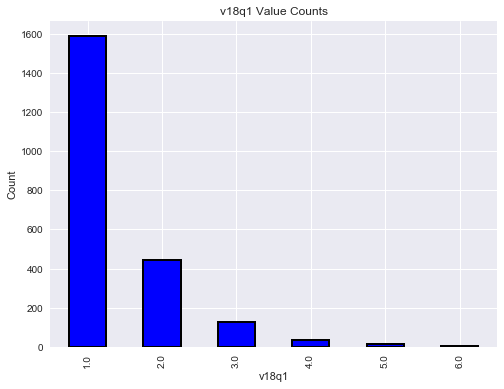

In [13]:
plot_value_counts(train, 'v18q1')

It looks like the most common number of tablets to own is 1 if we go only by the data that is present. However, we also need to think about the data that is missing. In this case, it could be that families with a `nan` in this category just do not own a tablet! If we look at the data definitions, we see that `v18q` indicates whether or not a family owns a tablet. We should investigate this column combined with the number of tablets to see if our hypothesis holds.

We can `groupby` the value of `v18q` (which is 1 for owns a tablet and 0 for does not) and then calculate the number of null values for `v18q1`. This will tell us if the null values represent that the family does not own a tablet.

In [14]:
train.groupby('v18q')['v18q1'].apply(lambda x: x.isnull().sum())

v18q
0    7319
1       0
Name: v18q1, dtype: int64

Every family that has `nan` for `v18q1` does not own a tablet. Therefore, we can fill in this missing value with zero.

In [15]:
train['v18q1'] = train['v18q1'].fillna(0)

The households that do not have a monthly rent payment generally own their own home. In a few other situations, we are not sure of the reason for the missing information. 

For the houses that are owned and have a missing monthly rent payment, we can set the value of the rent payment to zero. For the other homes, we can leave the missing values to be imputed but we'll add a flag (Boolean) column indicating that these households had missing values.

In [16]:
# Fill in households that own the house with 0 rent payment
train.loc[(train['tipovivi1'] == 1), 'v2a1'] = 0

# Create missing rent payment column
train['v2a1-missing'] = train['v2a1'].isnull()

train['v2a1-missing'].value_counts() #count how many houses have their rent missing

False    8588
True      946
Name: v2a1-missing, dtype: int64

__rez_esc__: years behind in school

The last column with a high percentage of missing values is `rez_esc` indicating years behind in school. For the families with a null value, is possible that they have no children currently in school. Let's test this out by finding the ages of those who have a missing value in this column and the ages of those who do not have a missing value.

In [17]:
train.loc[train['rez_esc'].notnull()]['age'].describe()

count    1613.000000
mean       12.262244
std         3.218671
min         7.000000
25%         9.000000
50%        12.000000
75%        15.000000
max        17.000000
Name: age, dtype: float64

What this tells us is that the oldest age with a missing value is 17. For anyone older than this, maybe we can assume that they are simply not in school. Let's look at the ages of those who have a missing value. 

In [18]:
train.loc[train['rez_esc'].isnull()]['age'].describe()

count    7921.000000
mean       38.842065
std        20.995254
min         0.000000
25%        24.000000
50%        38.000000
75%        54.000000
max        97.000000
Name: age, dtype: float64

Reading through some of the [discussions for this competition](https://www.kaggle.com/c/costa-rican-household-poverty-prediction/discussion/61403), we learn that this variable is only defined for individuals between 7 and 19. Anyone younger or older than this range presumably has no years behind and therefore the value should be set to 0. 
For this variable, if the individual is over 19 and they have a missing value, or if they are younger than 7 and have a missing value we can set it to zero. For anyone else, we'll leave the value to be imputed and add a boolean flag.

In [19]:
# If individual is over 19 or younger than 7 and missing years behind, set it to 0
train.loc[((train['age'] > 19) | (train['age'] < 7)) & (train['rez_esc'].isnull()), 'rez_esc'] = 0

# Add a flag for those between 7 and 19 with a missing value
train['rez_esc-missing'] = train['rez_esc'].isnull()

There is also one outlier in the `rez_esc` column. Again, if we read through the competition discussions, we learn that the maximum value for this variable is 5. Therefore, any values above 5 should be set to 5.

In [20]:
train.loc[train['rez_esc'] > 5, 'rez_esc'] = 5

## Column Definitions
 

We'll define different variables because we need to treat some of them in a different manner. Once we have the variables defined on each level, we can work to start aggregating them as needed.

The process is as follows

1. Break variables into household level and invididual level
2. Find suitable aggregations for the individual level data
    * Ordinal variables can use statistical aggregations
    * Boolean variables can also be aggregated but with fewer stats
3. Join the individual aggregations to the household level data

### Define Variable Categories

There are several different categories of variables:

1. Individual Variables: these are characteristics of each individual rather than the household
    * Boolean: Yes or No (0 or 1)
    * Ordered Discrete: Integers with an ordering
2. Household variables
    * Boolean: Yes or No
    * Ordered Discrete: Integers with an ordering
    * Continuous numeric
3. Squared Variables: derived from squaring variables in the data
4. Id variables: identifies the data and should not be used as features

Below we manually define the variables in each category. This is a little tedious, but also necessary. 

In [21]:
id_ = ['Id', 'idhogar', 'Target']

In [22]:
ind_bool = ['v18q', 'dis', 'male', 'female', 'estadocivil1', 'estadocivil2', 'estadocivil3', 
            'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
            'parentesco1', 'parentesco2',  'parentesco3', 'parentesco4', 'parentesco5', 
            'parentesco6', 'parentesco7', 'parentesco8',  'parentesco9', 'parentesco10', 
            'parentesco11', 'parentesco12', 'instlevel1', 'instlevel2', 'instlevel3', 
            'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 
            'instlevel9', 'mobilephone', 'rez_esc-missing']

ind_ordered = ['rez_esc', 'escolari', 'age']

In [23]:
hh_bool = ['hacdor', 'hacapo', 'v14a', 'refrig', 'paredblolad', 'paredzocalo', 
           'paredpreb','pisocemento', 'pareddes', 'paredmad',
           'paredzinc', 'paredfibras', 'paredother', 'pisomoscer', 'pisoother', 
           'pisonatur', 'pisonotiene', 'pisomadera',
           'techozinc', 'techoentrepiso', 'techocane', 'techootro', 'cielorazo', 
           'abastaguadentro', 'abastaguafuera', 'abastaguano',
            'public', 'planpri', 'noelec', 'coopele', 'sanitario1', 
           'sanitario2', 'sanitario3', 'sanitario5',   'sanitario6',
           'energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4', 
           'elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 
           'elimbasu5', 'elimbasu6', 'epared1', 'epared2', 'epared3',
           'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 
           'tipovivi1', 'tipovivi2', 'tipovivi3', 'tipovivi4', 'tipovivi5', 
           'computer', 'television', 'lugar1', 'lugar2', 'lugar3',
           'lugar4', 'lugar5', 'lugar6', 'area1', 'area2', 'v2a1-missing']

hh_ordered = [ 'rooms', 'r4h1', 'r4h2', 'r4h3', 'r4m1','r4m2','r4m3', 'r4t1',  'r4t2', 
              'r4t3', 'v18q1', 'tamhog','tamviv','hhsize','hogar_nin',
              'hogar_adul','hogar_mayor','hogar_total',  'bedrooms', 'qmobilephone']

hh_cont = ['v2a1', 'dependency', 'edjefe', 'edjefa', 'meaneduc', 'overcrowding']

In [24]:
sqr_ = ['SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 
        'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned', 'agesq']

#### Squared Variables

First, the easiest step: we'll remove all of the squared variables. Sometimes variables are squared or transformed as part of feature engineering because it can help linear models learn relationships that are non-linear. However, since we will be using more complex models, these squared features are redundant. They are highly correlated with the non-squared version, and hence can actually hurt our model by adding irrelevant information and also slowing down training.

For an example, let's take a look at `SQBage` vs `age`.

In [25]:
# Remove squared variables
train = train.drop(columns = sqr_)
train.shape

(9534, 136)

## Id Variables

These are pretty simple: they will be kept as is in the data since we need them for identification.

## Household Level Variables

First let's subset to the heads of household and then to the household level variables.

In [26]:
heads = train.loc[train['parentesco1'] == 1, :]
heads = heads[id_ + hh_bool + hh_cont + hh_ordered]
heads.shape

(2973, 99)

For most of the household level variables, we can simply keep them as is: since we want to make predictions for each household, we use these variables as features. However, we can also remove some redundant variables and also add in some more features derived from existing data. 

We see for a number of cases, there are more people living in the household than there are in the family. This gives us a good idea for a new feature: __the difference between these two measurements!__

Let's make this new feature.

In [27]:
heads['hhsize-diff'] = heads['tamviv'] - heads['hhsize']

## Per Capita Features

Additional features we can make calculate the number of certain measurements for each person in the household.

In [28]:
heads['phones-per-capita'] = heads['qmobilephone'] / heads['tamviv']
heads['tablets-per-capita'] = heads['v18q1'] / heads['tamviv']
heads['rooms-per-capita'] = heads['rooms'] / heads['tamviv']
heads['rent-per-capita'] = heads['v2a1'] / heads['tamviv']

In [29]:
household_feats = list(heads.columns)

# Individual Level Variables

There are two types of individual level variables: Boolean (1 or 0 for True or False) and ordinal (discrete values with a meaningful ordering). 

In [30]:
ind = train[id_ + ind_bool + ind_ordered]
ind.shape

(9534, 40)

In [31]:
# Define custom function
range_ = lambda x: x.max() - x.min()
range_.__name__ = 'range_'

# Group and aggregate
ind_agg = ind.drop(columns = 'Target').groupby('idhogar').agg(['min', 'max', 'sum', 'count', 'std', range_])
ind_agg.head()

v18q                           dis                ...   escolari  \
           min max sum count  std range_ min max sum count  ...        sum   
idhogar                                                     ...              
001ff74ca    1   1   2     2  0.0      0   0   0   0     2  ...         16   
003123ec2    0   0   0     4  0.0      0   0   0   0     4  ...         13   
004616164    0   0   0     2  0.0      0   0   0   0     2  ...         14   
004983866    0   0   0     2  0.0      0   0   0   0     2  ...         15   
005905417    0   0   0     3  0.0      0   0   0   0     3  ...         17   

                                  age                                  
          count        std range_ min max sum count        std range_  
idhogar                                                                
001ff74ca     2  11.313708     16   0  38  38     2  26.870058     38  
003123ec2     4   3.774917      7   1  24  51     4  12.446552     23  
004616164     2   5.656854      8  16  50  66     2  24.041631     34  
004983866     2   0.707107      1  16  59  75     2  30.405592     43  
005905417     3   4.932883      9   6  32  52     3  13.316656     26  

[5 rows x 216 columns]

Next we can rename the columns to make it easier to keep track.

In [32]:
# Rename the columns
new_col = []
for c in ind_agg.columns.levels[0]:
    
    for stat in ind_agg.columns.levels[1]:
        new_col.append(f'{c}-{stat}')
        
ind_agg.columns = new_col
ind_agg.head()

,v18q-min,v18q-max,v18q-sum,v18q-count,v18q-std,v18q-range_,dis-min,dis-max,dis-sum,dis-count,...,escolari-sum,escolari-count,escolari-std,escolari-range_,age-min,age-max,age-sum,age-count,age-std,age-range_
idhogar,,,,,,,,,,,,,,,,,,,,,
001ff74ca,1,1,2,2,0.0,0,0,0,0,2,...,16,2,11.313708,16,0,38,38,2,26.870058,38
003123ec2,0,0,0,4,0.0,0,0,0,0,4,...,13,4,3.774917,7,1,24,51,4,12.446552,23
004616164,0,0,0,2,0.0,0,0,0,0,2,...,14,2,5.656854,8,16,50,66,2,24.041631,34
004983866,0,0,0,2,0.0,0,0,0,0,2,...,15,2,0.707107,1,16,59,75,2,30.405592,43
005905417,0,0,0,3,0.0,0,0,0,0,3,...,17,3,4.932883,9,6,32,52,3,13.316656,26


### Investigating Errors in Individual Aggregates
Since new variables have been added, we need to re-evaluate the data to ensure that it is clean and error-free. First, we will start by investigating for missing values again.

In [33]:
# Number of missing in each column
missing = pd.DataFrame(ind_agg.isnull().sum()).rename(columns = {0: 'total'})

# Create a percentage missing
missing['percent'] = missing['total'] / len(train)

missing.sort_values('percent', ascending = False).head(10)

,total,percent
rez_esc-std,418,0.043843
estadocivil6-std,388,0.040696
parentesco11-std,388,0.040696
parentesco6-std,388,0.040696
instlevel9-std,388,0.040696
estadocivil2-std,388,0.040696
parentesco5-std,388,0.040696
instlevel8-std,388,0.040696
estadocivil3-std,388,0.040696
instlevel1-std,388,0.040696


We hypothesize that the NaN values are due to households with only 1 member, and investigate the reason for these values. Let's focus on what the STD really means. Whether there is a large difference between individual members in terms of:

instlevel2, =1 incomplete primary

instlevel3, =1 complete primary

instlevel4, =1 incomplete academic secondary level

instlevel8, =1 undergraduate and higher education

mobilephone, =1 if mobile phone

estadocivil2, =1 if free or coupled uunion

estadocivil3, =1 if married

estadocivil7, =1 if single

parentesco1, =1 if household head

age, Age in years


From the features above, all the features are binary variables (either 0 or 1) except for age. Given that most of the individual-level features are binary, the calculation of Standard Deviation of binary variables within a household does not hold much value in predicting the target feature (level of poverty).

Hence, we will remove all individual-level standard deviations that are binary:

In [34]:
#Append "-std" to all individual variables to get list of individual-level standard deviations
#Get columns from individual variables that are boolean

ind_bool_std = [col for col in ind_agg.columns if 'std' in col]

#Get list of std non-boolean variables
ind_ordered_std = []
for c in ind_ordered:
    ind_ordered_std.append(f'{c}-std')
    
#Remove non-boolean variable standard deviations from list
ind_bool_std = [x for x in ind_bool_std if x not in ind_ordered_std]
ind_bool_std

['v18q-std',
 'dis-std',
 'male-std',
 'female-std',
 'estadocivil1-std',
 'estadocivil2-std',
 'estadocivil3-std',
 'estadocivil4-std',
 'estadocivil5-std',
 'estadocivil6-std',
 'estadocivil7-std',
 'parentesco1-std',
 'parentesco2-std',
 'parentesco3-std',
 'parentesco4-std',
 'parentesco5-std',
 'parentesco6-std',
 'parentesco7-std',
 'parentesco8-std',
 'parentesco9-std',
 'parentesco10-std',
 'parentesco11-std',
 'parentesco12-std',
 'instlevel1-std',
 'instlevel2-std',
 'instlevel3-std',
 'instlevel4-std',
 'instlevel5-std',
 'instlevel6-std',
 'instlevel7-std',
 'instlevel8-std',
 'instlevel9-std',
 'mobilephone-std']

In [35]:
#Remove individual boolean standard deviation variable
ind_agg.drop(ind_bool_std, axis=1, inplace=True)
ind_agg.head()

,v18q-min,v18q-max,v18q-sum,v18q-count,v18q-range_,dis-min,dis-max,dis-sum,dis-count,dis-range_,...,escolari-sum,escolari-count,escolari-std,escolari-range_,age-min,age-max,age-sum,age-count,age-std,age-range_
idhogar,,,,,,,,,,,,,,,,,,,,,
001ff74ca,1,1,2,2,0,0,0,0,2,0,...,16,2,11.313708,16,0,38,38,2,26.870058,38
003123ec2,0,0,0,4,0,0,0,0,4,0,...,13,4,3.774917,7,1,24,51,4,12.446552,23
004616164,0,0,0,2,0,0,0,0,2,0,...,14,2,5.656854,8,16,50,66,2,24.041631,34
004983866,0,0,0,2,0,0,0,0,2,0,...,15,2,0.707107,1,16,59,75,2,30.405592,43
005905417,0,0,0,3,0,0,0,0,3,0,...,17,3,4.932883,9,6,32,52,3,13.316656,26


Having accounted for the NaN individual boolean variables, let's relook at the missing values in our dataset.

In [36]:
# Number of missing in each column
missing = pd.DataFrame(ind_agg.isnull().sum()).rename(columns = {0: 'total'})

# Create a percentage missing
missing['percent'] = missing['total'] / len(train)

missing.sort_values('percent', ascending = False).head(10)

,total,percent
rez_esc-std,418,0.043843
age-std,388,0.040696
escolari-std,388,0.040696
rez_esc-range_,3,0.000315
rez_esc-min,3,0.000315
rez_esc-max,3,0.000315
instlevel2-count,0,0.000000
instlevel1-min,0,0.000000
instlevel1-max,0,0.000000
instlevel1-sum,0,0.000000


Based on the table above, the top 2 variables having missing values likely because the household has only 1 person.
The other 4 variables relating to rez_esc, Years behind in school, might have missing values because the data was not captured for certain individuals in the household. We need to re-examine the individual variables in conjunction with the household variables to test our hypothesis.


In [37]:
# Merge on the household id
merged = heads.merge(ind_agg, on = 'idhogar', how = 'left')
merged.head()

,Id,idhogar,Target,hacdor,hacapo,v14a,refrig,paredblolad,paredzocalo,paredpreb,...,escolari-sum,escolari-count,escolari-std,escolari-range_,age-min,age-max,age-sum,age-count,age-std,age-range_
0,ID_279628684,21eb7fcc1,4,0,0,1,1,1,0,0,...,10,1,NaN,0,43,43,43,1,NaN,0
1,ID_f29eb3ddd,0e5d7a658,4,0,0,1,1,0,0,0,...,12,1,NaN,0,67,67,67,1,NaN,0
2,ID_68de51c94,2c7317ea8,4,0,0,1,1,0,0,0,...,11,1,NaN,0,92,92,92,1,NaN,0
3,ID_ec05b1a7b,2b58d945f,4,0,0,1,1,1,0,0,...,33,4,4.272002,9,8,38,100,4,14.899664,30
4,ID_1284f8aad,d6dae86b7,4,1,0,1,1,1,0,0,...,23,4,5.123475,11,7,30,76,4,11.690452,23


##### age-std and escolari-std

First, we need to confirm that the missing values are only due to households with 1 person.



In [38]:
missing = merged.loc[merged['age-std'].isnull() | merged['escolari-std'].isnull()]
#Check if any households have more than 1 person
missing_X = missing.loc[missing['tamhog'] != 1]

#merged.loc[merged['age-count'] != merged['tamhog']]
missing_X[['idhogar', 'age-std', 'age-count', 'escolari-std', 'escolari-count', 'tamhog', 'tamviv', 'hhsize', 'instlevel1-count']]

,idhogar,age-std,age-count,escolari-std,escolari-count,tamhog,tamviv,hhsize,instlevel1-count
1603,66701a0de,NaN,1,NaN,1,2,2,2,1
2955,053f09ebb,NaN,1,NaN,1,2,2,2,1


From the table above, we find that other aggregates like age-count, escolari-std all have a count of only 1. Perhaps the data has a discrepancy in recording the number of persons in the household. Let us investigate this further by finding out how many individual IDs match the 2 households.

In [39]:
#Get all rows in train dataset that contain the household IDs from missing_X
train[train.idhogar.isin(missing_X['idhogar'].tolist())]

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,lugar3,lugar4,lugar5,lugar6,area1,area2,age,Target,v2a1-missing,rez_esc-missing
5129,ID_cc1cb71fa,120000.0,0,5,0,1,1,0,0.0,0,...,0,0,0,0,0,1,49,4,False,False
9507,ID_139a33398,0.0,0,4,0,1,1,0,0.0,0,...,0,0,0,1,0,1,62,4,False,False


From the table above, these discrepancies occurred because 'tamhog' and the actual number of individuals in the dataset are different. Since we do not know the cause of this, we will simply change all age-std and escolari-std with NaN values to '0' values.

In [40]:
ind_agg[['age-std', 'escolari-std']] = ind_agg[['age-std', 'escolari-std']].replace(np.nan, 0)
ind_agg.head()

,v18q-min,v18q-max,v18q-sum,v18q-count,v18q-range_,dis-min,dis-max,dis-sum,dis-count,dis-range_,...,escolari-sum,escolari-count,escolari-std,escolari-range_,age-min,age-max,age-sum,age-count,age-std,age-range_
idhogar,,,,,,,,,,,,,,,,,,,,,
001ff74ca,1,1,2,2,0,0,0,0,2,0,...,16,2,11.313708,16,0,38,38,2,26.870058,38
003123ec2,0,0,0,4,0,0,0,0,4,0,...,13,4,3.774917,7,1,24,51,4,12.446552,23
004616164,0,0,0,2,0,0,0,0,2,0,...,14,2,5.656854,8,16,50,66,2,24.041631,34
004983866,0,0,0,2,0,0,0,0,2,0,...,15,2,0.707107,1,16,59,75,2,30.405592,43
005905417,0,0,0,3,0,0,0,0,3,0,...,17,3,4.932883,9,6,32,52,3,13.316656,26


#### rez-esc
Next, we will investigate the NaN values in rez-esc

In [41]:
missing_rezesc = merged.loc[merged['rez_esc-std'].isnull() | merged['rez_esc-range_'].isnull()]
#Check if any households do not have 1 person
missing_X = missing_rezesc.loc[missing_rezesc['tamhog'] != 1]
missing_X[['rez_esc-std', 'rez_esc-min', 'rez_esc-max', 'rez_esc-sum', 'rez_esc-range_', 'rez_esc-count', 'tamhog', 'tamviv']]



,rez_esc-std,rez_esc-min,rez_esc-max,rez_esc-sum,rez_esc-range_,rez_esc-count,tamhog,tamviv
5,NaN,0.0,0.0,0.0,0.0,1,2,2
119,NaN,0.0,0.0,0.0,0.0,1,2,2
143,NaN,0.0,0.0,0.0,0.0,1,2,2
237,NaN,0.0,0.0,0.0,0.0,1,2,2
449,NaN,0.0,0.0,0.0,0.0,1,2,2
555,NaN,0.0,0.0,0.0,0.0,1,2,2
582,NaN,0.0,0.0,0.0,0.0,1,2,2
586,NaN,NaN,NaN,0.0,NaN,0,2,2
660,NaN,NaN,NaN,0.0,NaN,0,2,2
1009,NaN,0.0,0.0,0.0,0.0,1,2,2


From the table above we find that there are 2 reasons for the NaN values:

1. There is only one individual recorded value of rez-esc but tamhog value is 2 - likely because some individuals in household have missing rez-esc.
2. There is somehow a case where 0 individuals are tied to a household - this is likely due to missing rez-esc values we had tagged earlier

In [42]:
#Get individuals where rez_esc_std is NaN and rez_esc is missing

train[train.idhogar.isin(missing_X['idhogar'].tolist()) & train['rez_esc-missing'] == True]

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,lugar3,lugar4,lugar5,lugar6,area1,area2,age,Target,v2a1-missing,rez_esc-missing
11,ID_de822510c,100000.0,0,3,0,1,1,0,0.0,0,...,0,0,0,0,1,0,18,4,False,True
376,ID_43fdf0633,NaN,0,4,0,1,1,1,1.0,0,...,0,0,0,0,1,0,19,3,True,True
456,ID_e6d2de913,180000.0,0,4,0,1,1,1,1.0,0,...,0,0,0,0,1,0,19,4,False,True
725,ID_4e9995fa3,170000.0,0,5,0,1,1,0,0.0,0,...,0,0,0,0,1,0,18,4,False,True
1394,ID_f477196dd,0.0,0,6,0,1,1,0,0.0,0,...,0,0,0,0,1,0,18,2,False,True
1732,ID_fb35d9d3d,300000.0,0,6,0,1,1,0,0.0,0,...,0,0,0,0,1,0,19,4,False,True
1831,ID_e4ff3aa81,176000.0,0,4,0,1,1,0,0.0,0,...,0,0,0,0,1,0,19,4,False,True
1840,ID_46ff87316,110000.0,0,1,0,1,1,0,0.0,0,...,0,0,0,0,1,0,18,4,False,True
1841,ID_69f50bf3e,110000.0,0,1,0,1,1,0,0.0,0,...,0,0,0,0,1,0,18,4,False,True
2049,ID_db3168f9f,180000.0,0,3,0,1,1,0,0.0,0,...,0,0,0,0,1,0,19,4,False,True


From the evaluation above, we can see that the reason for households with 1 or 0 count of rez_esc but more than 2 members of household was because the value of rez_esc was already NaN initially. We will replace all the aggregated values of rez_esc in the final dataset with the column mean values.

In [43]:
ind_agg[['rez_esc-std', 'rez_esc-min', 'rez_esc-max', 'rez_esc-range_']] = ind_agg[['rez_esc-std', 'rez_esc-min', 'rez_esc-max', 'rez_esc-range_']].replace(np.nan, ind_agg[['rez_esc-std', 'rez_esc-min', 'rez_esc-max', 'rez_esc-range_']].mean())
ind_agg.head()

,v18q-min,v18q-max,v18q-sum,v18q-count,v18q-range_,dis-min,dis-max,dis-sum,dis-count,dis-range_,...,escolari-sum,escolari-count,escolari-std,escolari-range_,age-min,age-max,age-sum,age-count,age-std,age-range_
idhogar,,,,,,,,,,,,,,,,,,,,,
001ff74ca,1,1,2,2,0,0,0,0,2,0,...,16,2,11.313708,16,0,38,38,2,26.870058,38
003123ec2,0,0,0,4,0,0,0,0,4,0,...,13,4,3.774917,7,1,24,51,4,12.446552,23
004616164,0,0,0,2,0,0,0,0,2,0,...,14,2,5.656854,8,16,50,66,2,24.041631,34
004983866,0,0,0,2,0,0,0,0,2,0,...,15,2,0.707107,1,16,59,75,2,30.405592,43
005905417,0,0,0,3,0,0,0,0,3,0,...,17,3,4.932883,9,6,32,52,3,13.316656,26


### Feature Selection (Individual Aggregates) 

As a first round of feature   selection, we can remove one out of every pair of variables with a correlation greater than 0.95. 

In [44]:
# Create correlation matrix
corr_matrix = ind_agg.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]
to_drop

['v18q-max',
 'dis-count',
 'male-count',
 'female-min',
 'female-max',
 'female-count',
 'female-range_',
 'estadocivil1-count',
 'estadocivil1-range_',
 'estadocivil2-sum',
 'estadocivil2-count',
 'estadocivil3-sum',
 'estadocivil3-count',
 'estadocivil4-sum',
 'estadocivil4-count',
 'estadocivil5-count',
 'estadocivil6-sum',
 'estadocivil6-count',
 'estadocivil7-count',
 'parentesco1-count',
 'parentesco1-range_',
 'parentesco2-sum',
 'parentesco2-count',
 'parentesco2-range_',
 'parentesco3-count',
 'parentesco3-range_',
 'parentesco4-count',
 'parentesco4-range_',
 'parentesco5-sum',
 'parentesco5-count',
 'parentesco5-range_',
 'parentesco6-count',
 'parentesco6-range_',
 'parentesco7-sum',
 'parentesco7-count',
 'parentesco7-range_',
 'parentesco8-sum',
 'parentesco8-count',
 'parentesco8-range_',
 'parentesco9-count',
 'parentesco9-range_',
 'parentesco10-count',
 'parentesco10-range_',
 'parentesco11-count',
 'parentesco11-range_',
 'parentesco12-count',
 'parentesco12-range_'

In [45]:
ind_agg = ind_agg.drop(columns = to_drop)
ind_feats = list(ind_agg.columns)

# Merge on the household id
final = heads.merge(ind_agg, on = 'idhogar', how = 'left')

print('Final features shape: ', final.shape)

Final features shape:  (2973, 217)


In [46]:
final.head()

,v18q-min,v18q-sum,v18q-count,v18q-range_,dis-min,dis-max,dis-sum,dis-range_,male-min,male-max,...,escolari-min,escolari-max,escolari-sum,escolari-std,escolari-range_,age-min,age-max,age-sum,age-std,age-range_
idhogar,,,,,,,,,,,,,,,,,,,,,
001ff74ca,1,2,2,0,0,0,0,0,0,0,...,0,16,16,11.313708,16,0,38,38,26.870058,38
003123ec2,0,0,4,0,0,0,0,0,0,1,...,0,7,13,3.774917,7,1,24,51,12.446552,23
004616164,0,0,2,0,0,0,0,0,1,1,...,3,11,14,5.656854,8,16,50,66,24.041631,34
004983866,0,0,2,0,0,0,0,0,0,1,...,7,8,15,0.707107,1,16,59,75,30.405592,43
005905417,0,0,3,0,0,0,0,0,0,1,...,0,9,17,4.932883,9,6,32,52,13.316656,26
006031de3,1,4,4,0,0,0,0,0,0,1,...,2,16,37,7.274384,14,8,39,94,16.258331,31
006555fe2,0,0,5,0,0,1,1,1,0,1,...,4,17,52,5.079370,13,40,79,291,18.753666,39
00693f597,0,0,4,0,0,0,0,0,0,1,...,3,11,30,3.415650,8,11,47,107,16.820127,36
006b64543,0,0,2,0,0,0,0,0,0,1,...,3,11,14,5.656854,8,32,54,86,15.556349,22


#### Addressing Final Missing Values (Household Level)

In [47]:
# Number of missing in each column
missing_final = pd.DataFrame(final.isnull().sum()).rename(columns = {0: 'total'})

# Create a percentage missing
missing_final['percent'] = missing_final['total'] / len(train)

missing_final.sort_values('percent', ascending = False).head(10)

,total,percent
rent-per-capita,300,0.031466
v2a1,300,0.031466
meaneduc,3,0.000315
Id,0,0.000000
parentesco4-min,0,0.000000
estadocivil7-range_,0,0.000000
parentesco1-min,0,0.000000
parentesco1-max,0,0.000000
parentesco1-sum,0,0.000000
parentesco2-min,0,0.000000


In [48]:
missing_final = final.loc[final['v2a1'].isnull() | final['rent-per-capita'].isnull()]
#Check if any households have more than 1 person
missing_final.head()

,Id,idhogar,Target,hacdor,hacapo,v14a,refrig,paredblolad,paredzocalo,paredpreb,...,escolari-min,escolari-max,escolari-sum,escolari-std,escolari-range_,age-min,age-max,age-sum,age-std,age-range_
59,ID_44031e6d2,322cefd2f,2,0,1,1,1,0,0,0,...,0,7,32,3.431877,7,1,52,175,19.125318,51
81,ID_694d4b0ce,ece1115ac,4,0,0,1,1,1,0,0,...,3,6,9,2.121320,3,40,65,105,17.677670,25
82,ID_d61734d32,fabb02be9,4,0,0,1,0,1,0,0,...,0,6,6,3.464102,6,42,59,146,9.073772,17
90,ID_84e79c9d1,0473832dd,4,0,0,1,1,0,0,0,...,3,9,24,2.581989,6,10,45,114,16.703293,35
92,ID_4f08bbe09,6833ac5dc,2,0,0,1,1,0,0,0,...,0,9,36,3.162278,9,1,36,119,12.172373,35


Recall that rent-per-capita is a calculated field based on v2a1, and v2a1 has missing values that we tagged earlier. We will simply replace all missing values in both variables with the column mean.

In [49]:
final[['v2a1', 'rent-per-capita']] = final[['v2a1', 'rent-per-capita']].replace(np.nan, final[['v2a1', 'rent-per-capita']].mean())
final.head()

,Id,idhogar,Target,hacdor,hacapo,v14a,refrig,paredblolad,paredzocalo,paredpreb,...,escolari-min,escolari-max,escolari-sum,escolari-std,escolari-range_,age-min,age-max,age-sum,age-std,age-range_
0,ID_279628684,21eb7fcc1,4,0,0,1,1,1,0,0,...,10,10,10,0.000000,0,43,43,43,0.000000,0
1,ID_f29eb3ddd,0e5d7a658,4,0,0,1,1,0,0,0,...,12,12,12,0.000000,0,67,67,67,0.000000,0
2,ID_68de51c94,2c7317ea8,4,0,0,1,1,0,0,0,...,11,11,11,0.000000,0,92,92,92,0.000000,0
3,ID_ec05b1a7b,2b58d945f,4,0,0,1,1,1,0,0,...,2,11,33,4.272002,9,8,38,100,14.899664,30
4,ID_1284f8aad,d6dae86b7,4,1,0,1,1,1,0,0,...,0,11,23,5.123475,11,7,30,76,11.690452,23


#### meaneduc
Lastly, let us investigate the 3 NaN values for meaneduc:

In [50]:
missing_meaneduc = final.loc[final['meaneduc'].isnull()]
missing_meaneduc[['meaneduc','tamhog', 'edjefe', 'edjefa', 'hogar_adul', 'hogar_nin']]

,meaneduc,tamhog,edjefe,edjefa,hogar_adul,hogar_nin
420,NaN,1,0,10,0,1
586,NaN,2,4,0,0,2
660,NaN,2,12,0,0,2


From the exploration table above, we can see that meaneduc is NaN for the 3 households because there are no adults in the households. Recall that meaneduc is defined as the average years of education for adults in the household. Hence, for the 3 households, we will replace the NaN values with 0.

In [51]:
final[['meaneduc']] = final[['meaneduc']].replace(np.nan, final[['meaneduc']].mean())
final.head()

,Id,idhogar,Target,hacdor,hacapo,v14a,refrig,paredblolad,paredzocalo,paredpreb,...,escolari-min,escolari-max,escolari-sum,escolari-std,escolari-range_,age-min,age-max,age-sum,age-std,age-range_
0,ID_279628684,21eb7fcc1,4,0,0,1,1,1,0,0,...,10,10,10,0.000000,0,43,43,43,0.000000,0
1,ID_f29eb3ddd,0e5d7a658,4,0,0,1,1,0,0,0,...,12,12,12,0.000000,0,67,67,67,0.000000,0
2,ID_68de51c94,2c7317ea8,4,0,0,1,1,0,0,0,...,11,11,11,0.000000,0,92,92,92,0.000000,0
3,ID_ec05b1a7b,2b58d945f,4,0,0,1,1,1,0,0,...,2,11,33,4.272002,9,8,38,100,14.899664,30
4,ID_1284f8aad,d6dae86b7,4,1,0,1,1,1,0,0,...,0,11,23,5.123475,11,7,30,76,11.690452,23


Finally, let us verify once more that there are no more missing values in the data.

In [52]:
# Number of missing in each column
missing = pd.DataFrame(final.isnull().sum()).rename(columns = {0: 'total'})

# Create a percentage missing
missing['percent'] = missing['total'] / len(train)

missing.sort_values('percent', ascending = False).head(10)

,total,percent
Id,0,0.0
parentesco4-max,0,0.0
estadocivil7-sum,0,0.0
estadocivil7-range_,0,0.0
parentesco1-min,0,0.0
parentesco1-max,0,0.0
parentesco1-sum,0,0.0
parentesco2-min,0,0.0
parentesco2-max,0,0.0
parentesco3-min,0,0.0


In [53]:
final.to_csv('final.csv')